## Test the installation of JAX

In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


## Try jax with simple matrix multiplication

In [3]:
# multiple two matrices
size = 3000
x = random.normal(key, (size, size), dtype=jnp.float32)
%timeit jnp.dot(x, x.T)

275 ms ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
# use regular NumPy arrays for the same computation
import numpy as np
x = np.random.normal(size=(size,size)).astype(np.float32)
%timeit jnp.dot(x, x.T)

252 ms ± 5.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Use *jit()* to speed up functions in jax

In [5]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

# call selu function without jit decorator
x = random.normal(key, (1000000,))
%timeit selu(x)

4.8 ms ± 99.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
# make selu function jit
selu_jit = jit(selu)
%timeit selu_jit(x)

515 µs ± 14.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
# another way to use jit, use decorator in function
@jit
def selu_with_decorator(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x>0, x, alpha * jnp.exp(x) - alpha)

%timeit selu_with_decorator(x)

572 µs ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Use *grad()* to take derivatives

In [11]:
def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))

x_small = jnp.arange(3.)
print(x_small)

# derivative of this function
derivative_fn = grad(sum_logistic)
print(derivative_fn(x_small))

# take derivative of derivative
derivative2_fn = jit(grad(derivative_fn))
print(derivative2_fn(1.0))

[0. 1. 2.]
[0.25       0.19661197 0.10499357]
-0.09085775


## Use *vmap()* for auto-vectorization

In [13]:
# 3 ways to promote matrix-vector products into matrix-matrix products
mat = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(v):
    return jnp.dot(mat, v)

# (1). Naive 
def naive_batched_apply_matrix(v_batched):
    return jnp.stack([apply_matrix(v) for v in v_batched])
print('(1) Naively batched')
%timeit naive_batched_apply_matrix(batched_x)

(1) Naively batched
2.96 ms ± 57 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
# (2). Manually batched
@jit
def batched_apply_matrix(v_batched):
    return jnp.dot(v_batched, mat.T)

print('(2) Manually batched')
%timeit batched_apply_matrix(batched_x)

(2) Manually batched
12.5 µs ± 78 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [15]:
# (3). Auto-vectorized with vmap
@jit
def vmap_batched_apply_matrix(v_batched):
    return vmap(apply_matrix)(v_batched)

print('(3) Auto-vectorize batched with vmap')
%timeit vmap_batched_apply_matrix(batched_x)

(3) Auto-vectorize batched with vmap
19.5 µs ± 179 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## JAX and Numpy

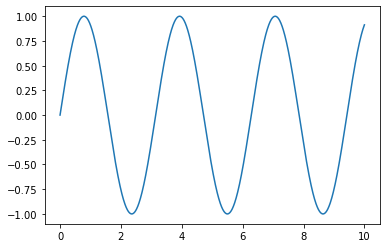

In [17]:
import matplotlib.pyplot as plt

x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np)

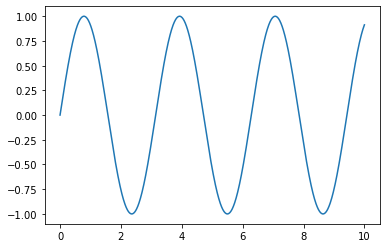

In [21]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [22]:
# differences
# (1) Numpy array is mutable but JAX array is not
x = np.arange(10)
x[0] = 10
print(x)

x = jnp.arange(10)
y = x.at[0].set(10)
print(x, y)

[10  1  2  3  4  5  6  7  8  9]
[0 1 2 3 4 5 6 7 8 9] [10  1  2  3  4  5  6  7  8  9]


## When to use *JIT* and when not to

In [28]:
def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_jit = jit(norm)

np.random.seed(1701)
X = jnp.array(np.random.rand(10000, 10))
print(np.allclose(norm(X), norm_jit(X), atol=1E-6))

%timeit norm(X)
%timeit norm_jit(X)

True
343 µs ± 29.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
271 µs ± 30.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [33]:
# JIT requires all arrays to have static shapes
def get_negatives(x):
    return x[x < 0]

# the function above cannot be called in JIT mode
x = jnp.array(np.random.randn(10))
print(get_negatives(x))

get_negatives_JIT = jit(get_negatives)
#print(get_negatives_JIT(x))     # this call will return with error

[-0.16529104 -0.5616348  -0.02158209 -0.37602973 -0.82070136]


## JIT mechanics: *tracing* and *static variables*

In [39]:
# Static operations are evaluated at compile-time in Python; \
# traced operations are compiled & evaluated at run-time in XLA.

@jit
def f(x, y):
    print("Running f():")
    print("    x = {}".format(x))
    print("    y = {}".format(y))
    result = jnp.dot(x+1, y+1)
    print("    result = {}".format(result))
    return result

# The first time calling f(), compilation happens
x = np.random.randn(3, 4)
y = np.random.randn(4)
print(x, y)
print("returned result: {}\n".format(f(x, y)))

# The second time calling f(), there won't be prints as is compiled already 
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print("returned result: {}\n".format(f(x2, y2)))

# show the JAX expression
from jax import make_jaxpr
make_jaxpr(f)(x, y)

[[ 0.61932998  0.83296526 -0.01022205  0.78267283]
 [-1.24735167  0.33722331 -0.07733002  1.03787083]
 [-1.36768645  0.10584496 -0.59179791  0.2473182 ]] [ 0.82241489 -1.42033257  2.09525327  0.06253995]
Running f():
    x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=0/1)>
    y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=0/1)>
    result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=0/1)>
returned result: [7.1384106 4.008361  1.4539143]

returned result: [-1.5073116   0.45682916 -0.09138716]

Running f():
    x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/1)>
    y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/1)>
    result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/1)>


{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3] = xla_call[
      call_jaxpr={ lambda ; d:f32[3,4] e:f32[4]. let
          f:f32[3,4] = add d 1.0
          g:f32[4] = add e 1.0
          h:f32[3] = dot_general[
            dimension_numbers=(((1,), (0,)), ((), ()))
            precision=None
            preferred_element_type=None
          ] f g
        in (h,) }
      name=f
    ] a b
  in (c,) }

In [45]:
# A useful pattern is to use numpy for operations that \
# should be static (i.e. done at compile-time), \
# and use jax.numpy for operations that should be \
# traced (i.e. compiled and executed at run-time).

# a standard convention in JAX programs is to "import numpy as np" \
# and "import jax.numpy as jnp" so that both interfaces are available\
#  for finer control over whether operations are performed \
# in a static matter (with numpy, once at compile-time) or \
# a traced manner (with jax.numpy, optimized at run-time).

# e.g., this is wrong, shape is not static, cannot use jnp
@jit
def f(x):
  return x.reshape(jnp.array(x.shape).prod())
#f(x)

# e.g., this is right, use np for non-static shape
@jit
def f(x):
  return x.reshape((np.prod(x.shape),))
f(x)


DeviceArray([ 0.61933   ,  0.83296525, -0.01022205,  0.7826728 ,
             -1.2473516 ,  0.33722332, -0.07733002,  1.0378709 ,
             -1.3676865 ,  0.10584496, -0.5917979 ,  0.2473182 ],            dtype=float32)